# Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# Reading the Dataset

In [3]:
weather = pd.read_csv("weather.csv")
weather.head()

FileNotFoundError: [Errno 2] No such file or directory: 'weather.csv'

# Exploratory Data Analysis

In [3]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29889 entries, 0 to 29888
Data columns (total 9 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   date                                         29889 non-null  object 
 1   maxtp(Maximum Air Temperature - degrees C)   29889 non-null  float64
 2   mintp(Minimum Air Temperature - degrees C)   29889 non-null  float64
 3   gmin(Grass Minimum Temperature - degrees C)  29889 non-null  object 
 4   rain(Precipitation Amount - mm)              29889 non-null  float64
 5   cbl (Mean CBL Pressure-hpa)                  29889 non-null  float64
 6   wdsp(Mean Wind Speed - knot)                 29889 non-null  float64
 7   pe(Potential Evapotranspiration - mm)        29889 non-null  float64
 8   evap(Evaporation -mm)                        29889 non-null  object 
dtypes: float64(6), object(3)
memory usage: 2.1+ MB


# Subsetting of the dataset based on which we have to do Time Series Analysis

In [4]:
weather = weather[["date","maxtp(Maximum Air Temperature - degrees C)"]]
weather.head()

,date,maxtp(Maximum Air Temperature - degrees C)
0,1-Jan-42,9.7
1,2-Jan-42,9.9
2,3-Jan-42,11.2
3,4-Jan-42,9.2
4,5-Jan-42,3.5


In [5]:
weather['date'] = pd.to_datetime(weather['date'], format = '%d-%b-%y')
weather.dtypes

date                                          datetime64[ns]
maxtp(Maximum Air Temperature - degrees C)           float64
dtype: object

In [6]:
weather['date'] = weather['date'].apply(lambda x: x.replace(year= x.year - 100) if x.year > 2023 else x)
weather.head()

,date,maxtp(Maximum Air Temperature - degrees C)
0,1942-01-01,9.7
1,1942-01-02,9.9
2,1942-01-03,11.2
3,1942-01-04,9.2
4,1942-01-05,3.5


## Setting the date as index 

In [7]:
weather.set_index('date', inplace= True)
weather.head()

,maxtp(Maximum Air Temperature - degrees C)
date,
1942-01-01,9.7
1942-01-02,9.9
1942-01-03,11.2
1942-01-04,9.2
1942-01-05,3.5


# Splitting the data into training and testing set

In [8]:
train = weather['2019-01-01':'2022-12-31']
test = weather['2023-01-01':'2023-10-31']

In [9]:
train

,maxtp(Maximum Air Temperature - degrees C)
date,
2019-01-01,9.2
2019-01-02,7.6
2019-01-03,7.9
2019-01-04,6.5
2019-01-05,8.4
...,...
2022-12-27,11.1
2022-12-28,11.3
2022-12-29,9.6


In [10]:
test

,maxtp(Maximum Air Temperature - degrees C)
date,
2023-01-01,6.8
2023-01-02,6.1
2023-01-03,13.3
2023-01-04,12.6
2023-01-05,12.6
...,...
2023-10-27,13.2
2023-10-28,14.1
2023-10-29,12.4


## Plotting the data based on which we wil further decompose the data

Text(0, 0.5, 'maxtp')

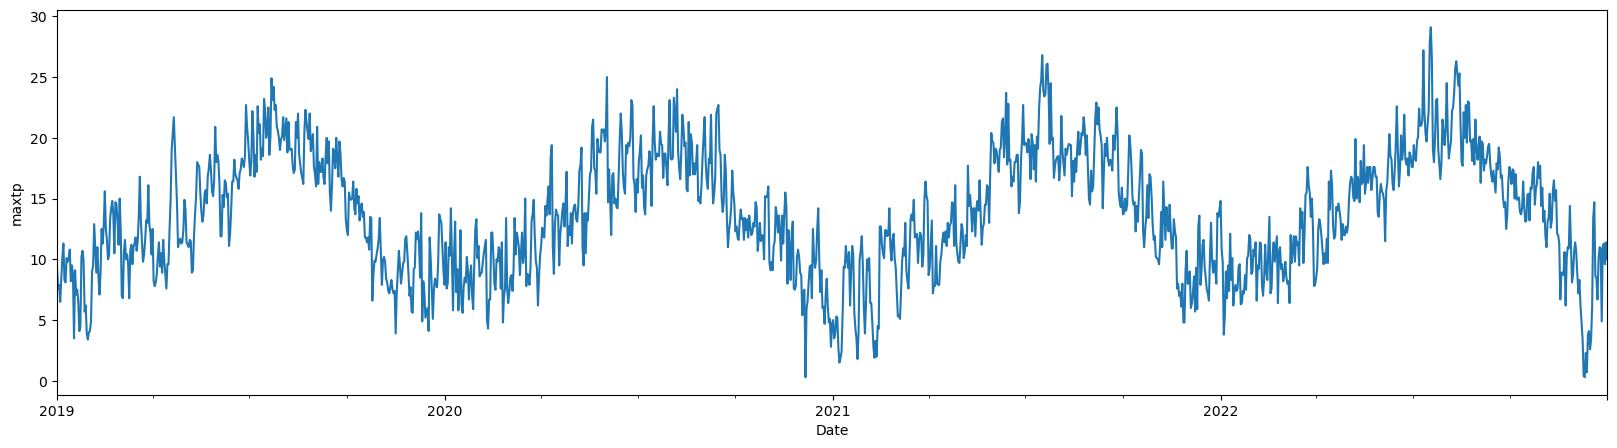

In [11]:
plt.figure(figsize= (20,5))
train['maxtp(Maximum Air Temperature - degrees C)'].plot()
plt.xlabel("Date")
plt.ylabel("maxtp")

## Decomposition of our Time Series Analysis

In [12]:
decompose = seasonal_decompose(train['maxtp(Maximum Air Temperature - degrees C)'], model = 'multiplicative')

<Figure size 2000x500 with 0 Axes>

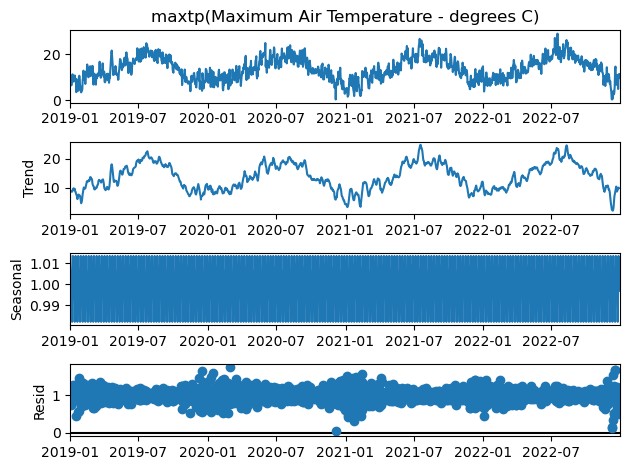

In [13]:
plt.figure(figsize= (20,5))
decompose.plot()
plt.show()

### (a) Simple Time Series Model

#### (i) Simple moving average

In [14]:
train['mov_avg2'] = train['maxtp(Maximum Air Temperature - degrees C)'].rolling(window = 2).mean()
train['mov_avg3'] = train['maxtp(Maximum Air Temperature - degrees C)'].rolling(window = 3).mean()

C:\Users\Yash Bhargava\AppData\Local\Temp\ipykernel_9212\3047433133.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['mov_avg2'] = train['maxtp(Maximum Air Temperature - degrees C)'].rolling(window = 2).mean()
C:\Users\Yash Bhargava\AppData\Local\Temp\ipykernel_9212\3047433133.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['mov_avg3'] = train['maxtp(Maximum Air Temperature - degrees C)'].rolling(window = 3).mean()


In [15]:
train

,maxtp(Maximum Air Temperature - degrees C),mov_avg2,mov_avg3
date,,,
2019-01-01,9.2,NaN,NaN
2019-01-02,7.6,8.40,NaN
2019-01-03,7.9,7.75,8.233333
2019-01-04,6.5,7.20,7.333333
2019-01-05,8.4,7.45,7.600000
...,...,...,...
2022-12-27,11.1,8.00,8.966667
2022-12-28,11.3,11.20,9.100000
2022-12-29,9.6,10.45,10.666667


#### (ii) Weighted moving average

In [16]:
weights = np.array([0.4, 0.35, 0.25])
train['weight_mov_avg3'] = train['maxtp(Maximum Air Temperature - degrees C)'].rolling(len(weights)).apply(lambda x:np.sum(weights*x))

C:\Users\Yash Bhargava\AppData\Local\Temp\ipykernel_9212\2613567415.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['weight_mov_avg3'] = train['maxtp(Maximum Air Temperature - degrees C)'].rolling(len(weights)).apply(lambda x:np.sum(weights*x))


In [17]:
train['weight_mov_avg3'].dropna()

date
2019-01-03     8.315
2019-01-04     7.430
2019-01-05     7.535
2019-01-06     8.065
2019-01-07     9.720
               ...  
2022-12-27     8.850
2022-12-28     8.670
2022-12-29    10.795
2022-12-30    10.730
2022-12-31    10.330
Name: weight_mov_avg3, Length: 1459, dtype: float64

In [18]:
train

,maxtp(Maximum Air Temperature - degrees C),mov_avg2,mov_avg3,weight_mov_avg3
date,,,,
2019-01-01,9.2,NaN,NaN,NaN
2019-01-02,7.6,8.40,NaN,NaN
2019-01-03,7.9,7.75,8.233333,8.315
2019-01-04,6.5,7.20,7.333333,7.430
2019-01-05,8.4,7.45,7.600000,7.535
...,...,...,...,...
2022-12-27,11.1,8.00,8.966667,8.850
2022-12-28,11.3,11.20,9.100000,8.670
2022-12-29,9.6,10.45,10.666667,10.795


## Plotting the values of moving and weighted moving average

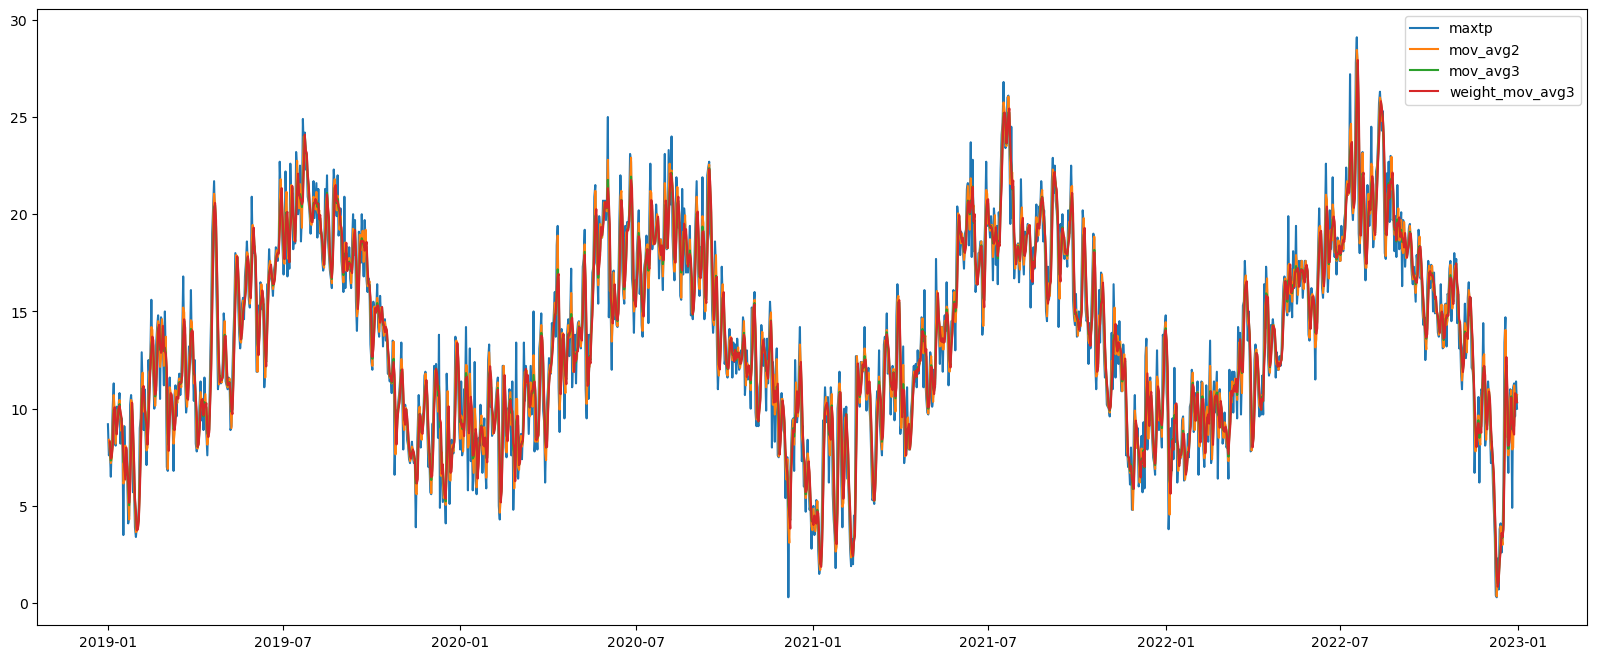

In [19]:
plt.figure(figsize= (20,8))
plt.plot(train['maxtp(Maximum Air Temperature - degrees C)'], label = 'maxtp')
plt.plot(train['mov_avg2'], label = 'mov_avg2')
plt.plot(train['mov_avg3'], label = 'mov_avg3')
plt.plot(train['weight_mov_avg3'], label = 'weight_mov_avg3')
plt.legend()
plt.show()

### (b) Exponential Smoothing Model

#### (i) Simple Exponential Smoothing Model

In [20]:
simp_exp_sm = SimpleExpSmoothing(train['maxtp(Maximum Air Temperature - degrees C)']).fit()

C:\Users\Yash Bhargava\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [21]:
simp_exp_sm_forecast = simp_exp_sm.forecast(len(test))
simp_exp_sm_forecast

2023-01-01    10.311592
2023-01-02    10.311592
2023-01-03    10.311592
2023-01-04    10.311592
2023-01-05    10.311592
                ...    
2023-10-27    10.311592
2023-10-28    10.311592
2023-10-29    10.311592
2023-10-30    10.311592
2023-10-31    10.311592
Freq: D, Length: 304, dtype: float64

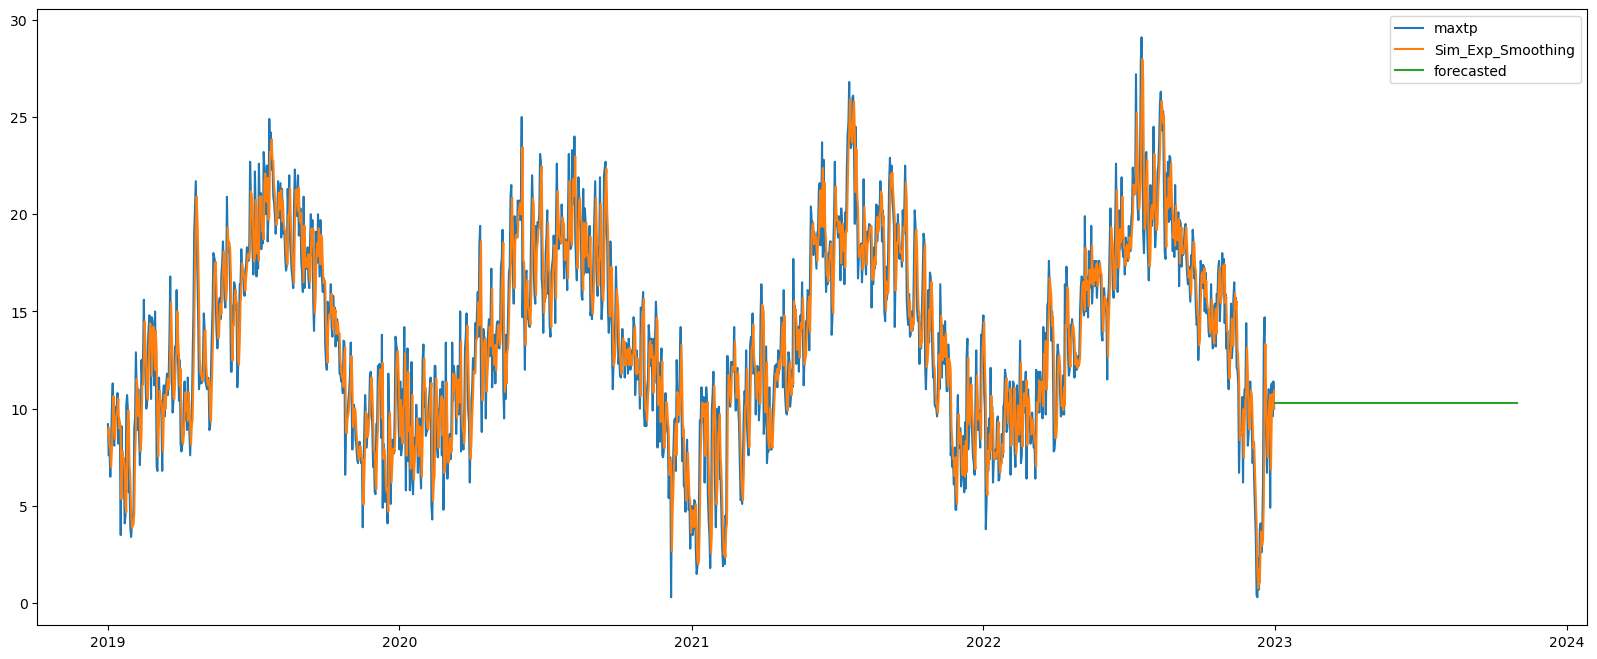

In [22]:
plt.figure(figsize=(20,8))
plt.plot(train['maxtp(Maximum Air Temperature - degrees C)'] , label = 'maxtp')
plt.plot(simp_exp_sm.fittedvalues, label = 'Sim_Exp_Smoothing')
plt.plot(simp_exp_sm_forecast, label = 'forecasted')
plt.legend()
plt.show()

In [23]:
print(simp_exp_sm.summary())

                                   SimpleExpSmoothing Model Results                                   
Dep. Variable:     maxtp(Maximum Air Temperature - degrees C)   No. Observations:                 1461
Model:                                     SimpleExpSmoothing   SSE                           7364.124
Optimized:                                               True   AIC                           2367.166
Trend:                                                   None   BIC                           2377.740
Seasonal:                                                None   AICC                          2367.193
Seasonal Periods:                                        None   Date:                 Mon, 01 Jan 2024
Box-Cox:                                                False   Time:                         21:01:41
Box-Cox Coeff.:                                          None                                         
                       coeff                 code              optimized 

In [24]:
sim_exp_smooth_mae = mean_absolute_error(test['maxtp(Maximum Air Temperature - degrees C)'], simp_exp_sm_forecast)
sim_exp_smooth_mape = mean_absolute_percentage_error(test['maxtp(Maximum Air Temperature - degrees C)'], simp_exp_sm_forecast)
simp_exp_smooth_rmse = np.sqrt(mean_squared_error(test['maxtp(Maximum Air Temperature - degrees C)'], simp_exp_sm_forecast))
print("Mean Absolute Error (MAE): ",sim_exp_smooth_mae)
print("Mean Absolute Percentage Error (MAPE): ",sim_exp_smooth_mape)
print("Root Mean Squared Error (RMSE): ",sim_exp_smooth_mae)

Mean Absolute Error (MAE):  5.6316945861887175
Mean Absolute Percentage Error (MAPE):  0.375680863292794
Root Mean Squared Error (RMSE):  5.6316945861887175


#### (ii) Holt's Linear Trend Model

In [25]:
holt_model = Holt(train['maxtp(Maximum Air Temperature - degrees C)']).fit()

C:\Users\Yash Bhargava\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [26]:
holt_model_forecast = holt_model.forecast(len(test))
holt_model_forecast

2023-01-01    10.313288
2023-01-02    10.314411
2023-01-03    10.315534
2023-01-04    10.316656
2023-01-05    10.317779
                ...    
2023-10-27    10.648989
2023-10-28    10.650112
2023-10-29    10.651234
2023-10-30    10.652357
2023-10-31    10.653480
Freq: D, Length: 304, dtype: float64

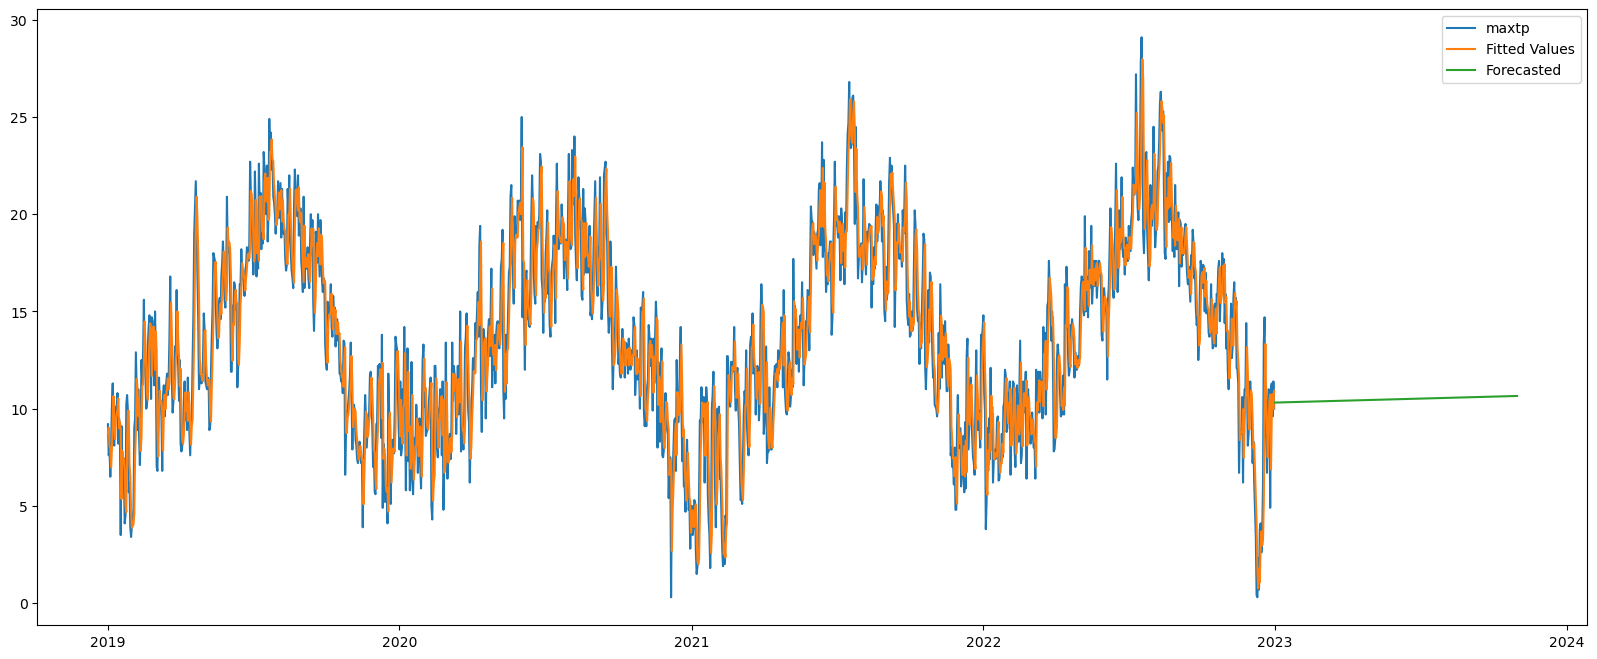

In [27]:
plt.figure(figsize=(20,8))
plt.plot(train['maxtp(Maximum Air Temperature - degrees C)'] , label = 'maxtp')
plt.plot(holt_model.fittedvalues, label = 'Fitted Values')
plt.plot(holt_model_forecast, label = 'Forecasted')
plt.legend()
plt.show()

In [28]:
print(holt_model.summary())

                                          Holt Model Results                                          
Dep. Variable:     maxtp(Maximum Air Temperature - degrees C)   No. Observations:                 1461
Model:                                                   Holt   SSE                           7364.120
Optimized:                                               True   AIC                           2371.165
Trend:                                               Additive   BIC                           2392.313
Seasonal:                                                None   AICC                          2371.223
Seasonal Periods:                                        None   Date:                 Mon, 01 Jan 2024
Box-Cox:                                                False   Time:                         21:01:42
Box-Cox Coeff.:                                          None                                         
                       coeff                 code              optimized 

In [29]:
holt_model_mae = mean_absolute_error(test['maxtp(Maximum Air Temperature - degrees C)'], holt_model_forecast)
holt_model_mape = mean_absolute_percentage_error(test['maxtp(Maximum Air Temperature - degrees C)'], holt_model_forecast)
holt_model_rmse = np.sqrt(mean_squared_error(test['maxtp(Maximum Air Temperature - degrees C)'], holt_model_forecast))
print("Mean Absolute Error (MAE): ",holt_model_mae)
print("Mean Absolute Percentage Error (MAPE): ",holt_model_mape)
print("Root Mean Squared Error (RMSE): ",holt_model_rmse)

Mean Absolute Error (MAE):  5.478792364678225
Mean Absolute Percentage Error (MAPE):  0.36719731528003036
Root Mean Squared Error (RMSE):  6.544853742070359


#### (iii) Holtz Winters Model

In [30]:
holt_winters_model = ExponentialSmoothing(train['maxtp(Maximum Air Temperature - degrees C)'],
                                          trend='additive',seasonal='multiplicative', 
                                          seasonal_periods= len(test)).fit()

C:\Users\Yash Bhargava\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Yash Bhargava\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [31]:
holt_winters_model_forecast = holt_winters_model.forecast(len(test))
holt_winters_model_forecast

2023-01-01    11.812476
2023-01-02    10.537686
2023-01-03     9.917332
2023-01-04    10.157801
2023-01-05     9.290492
                ...    
2023-10-27    11.201020
2023-10-28    10.770775
2023-10-29    10.432530
2023-10-30    10.338390
2023-10-31    10.711327
Freq: D, Length: 304, dtype: float64

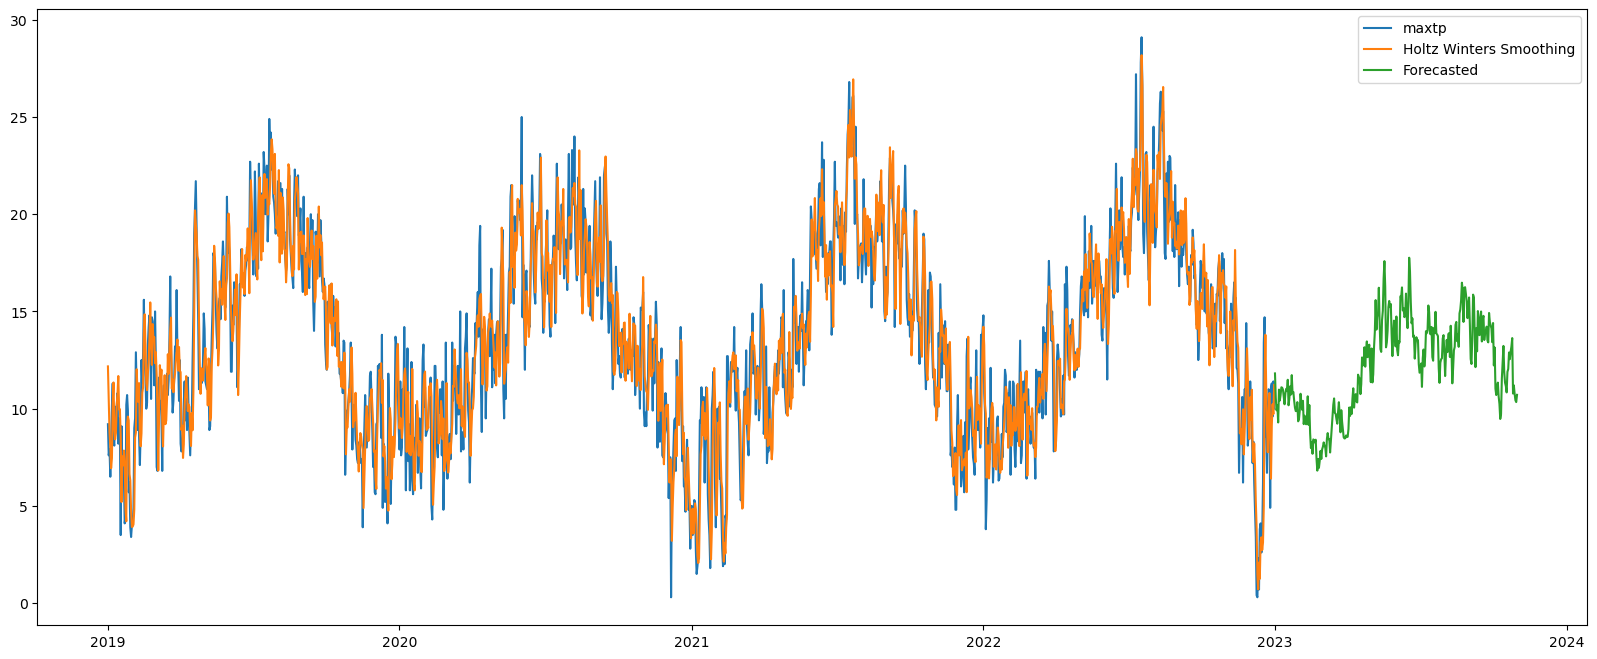

In [32]:
plt.figure(figsize=(20,8))
plt.plot(train['maxtp(Maximum Air Temperature - degrees C)'] , label = 'maxtp')
plt.plot(holt_winters_model.fittedvalues, label = 'Holtz Winters Smoothing')
plt.plot(holt_winters_model_forecast, label = 'Forecasted')
plt.legend()
plt.show()

In [33]:
print(holt_winters_model.summary())

                                  ExponentialSmoothing Model Results                                  
Dep. Variable:     maxtp(Maximum Air Temperature - degrees C)   No. Observations:                 1461
Model:                                   ExponentialSmoothing   SSE                           5848.714
Optimized:                                               True   AIC                           2642.554
Trend:                                               Additive   BIC                           4270.912
Seasonal:                                      Multiplicative   AICC                          2810.224
Seasonal Periods:                                         304   Date:                 Mon, 01 Jan 2024
Box-Cox:                                                False   Time:                         21:02:06
Box-Cox Coeff.:                                          None                                         
                           coeff                 code              optimi

In [34]:
holt_winters_model_mae = mean_absolute_error(test['maxtp(Maximum Air Temperature - degrees C)'],holt_winters_model_forecast)
holt_winters_model_mape = mean_absolute_percentage_error(test['maxtp(Maximum Air Temperature - degrees C)'], holt_winters_model_forecast)
holt_winters_model_rmse = np.sqrt(mean_squared_error(test['maxtp(Maximum Air Temperature - degrees C)'], holt_winters_model_forecast))
print("Mean Absolute Error (MAE): ",holt_winters_model_mae)
print("Mean Absolute Percentage Error (MAPE): ",holt_winters_model_mape)
print("Root Mean Squared Error (RMSE): ",holt_winters_model_rmse)

Mean Absolute Error (MAE):  3.7356305891194763
Mean Absolute Percentage Error (MAPE):  0.268252077996197
Root Mean Squared Error (RMSE):  4.638421198795864


### Checking for Stationarity using Augmented Dickey Fuller Test

<AxesSubplot:xlabel='date'>

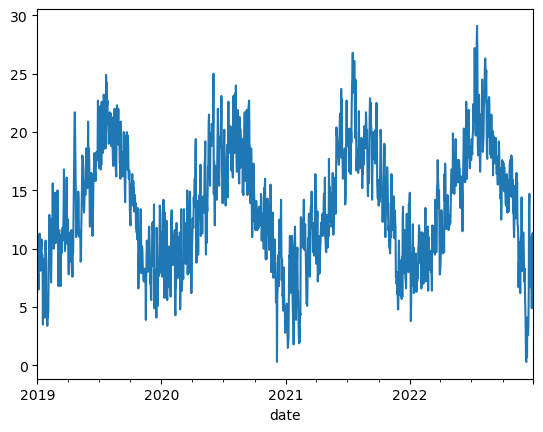

In [35]:
train['maxtp(Maximum Air Temperature - degrees C)'].plot()

In [36]:
def get_adfuller (ts):
    result = pd.Series(adfuller(ts)[0:4], 
          index =["Test Statistic", "p-value", "Lags Used", "Number of Observations"] )
    return result

In [37]:
get_adfuller(train['maxtp(Maximum Air Temperature - degrees C)'])

Test Statistic              -2.663824
p-value                      0.080510
Lags Used                   17.000000
Number of Observations    1443.000000
dtype: float64

In [38]:
First_Difference = pd.DataFrame(train['maxtp(Maximum Air Temperature - degrees C)'].diff(1).dropna())

In [39]:
get_adfuller(First_Difference)

Test Statistic           -1.332610e+01
p-value                   6.316924e-25
Lags Used                 1.600000e+01
Number of Observations    1.443000e+03
dtype: float64

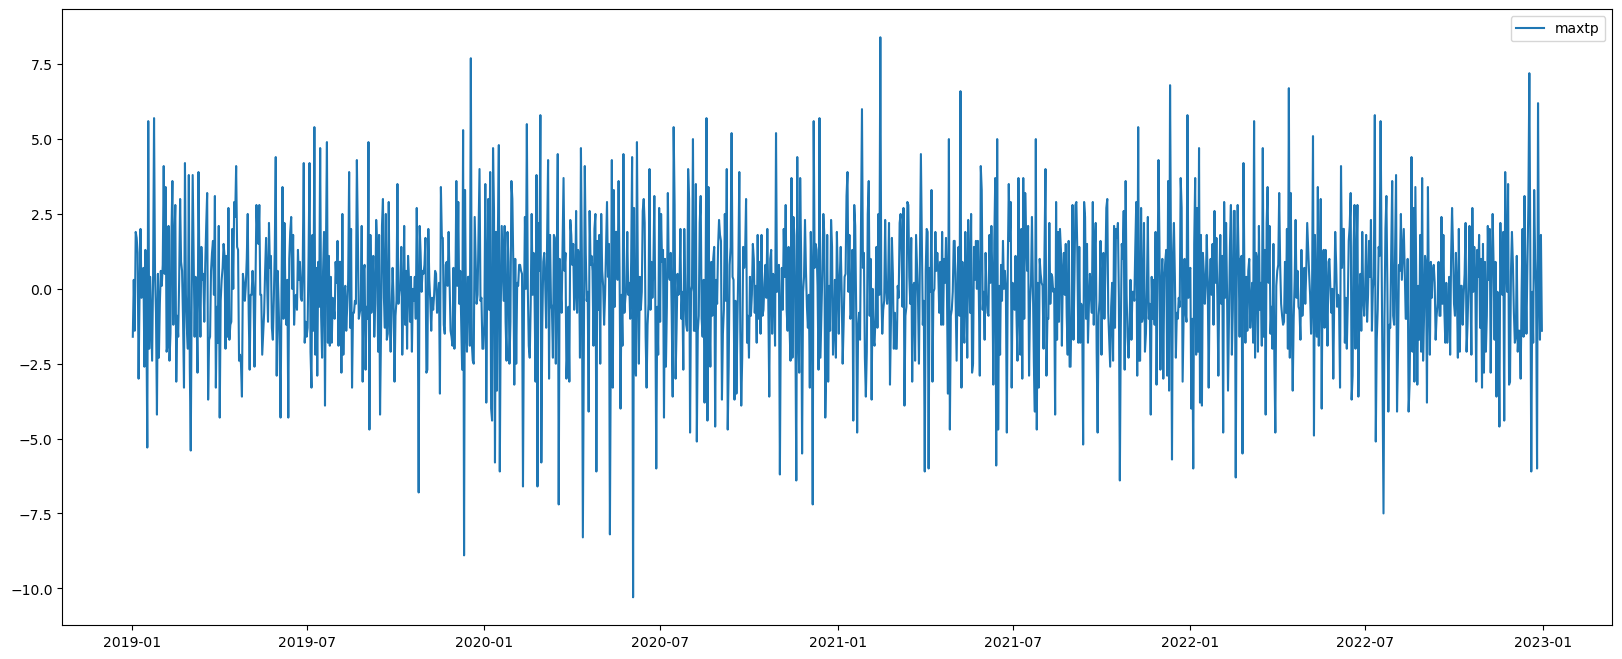

In [40]:
plt.figure(figsize= (20,8))
plt.plot(First_Difference, label = 'maxtp')
plt.legend()
plt.show()

## Plotting the ACF Plot

In [1]:
plt.figure(figsize=(12,5))
plot_acf(train['maxtp(Maximum Air Temperature - degrees C)'], lags = 50)
plt.show()

NameError: name 'plt' is not defined

## Plotting the PACF plot

C:\Users\Yash Bhargava\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 1200x500 with 0 Axes>

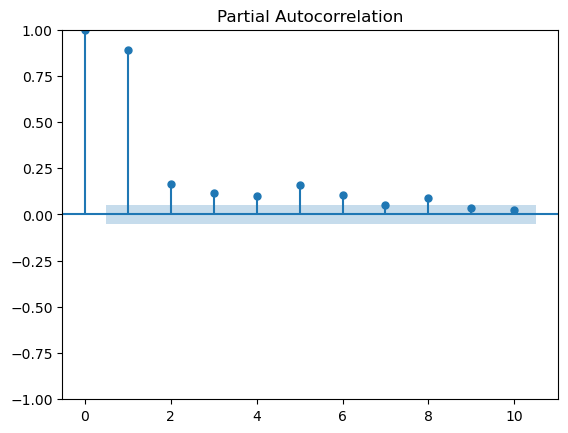

In [42]:
plt.figure(figsize=(12,5))
plot_pacf(train['maxtp(Maximum Air Temperature - degrees C)'], lags = 10)
plt.show()

## ARIMA (Auto Regressive Integrated Moving Average)

### ARIMA(5,1,7)

In [43]:
model517 = ARIMA(train['maxtp(Maximum Air Temperature - degrees C)'], order= (5,1,7)).fit()
print(model517.summary())

C:\Users\Yash Bhargava\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Yash Bhargava\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Yash Bhargava\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Yash Bhargava\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                           SARIMAX Results                                            
Dep. Variable:     maxtp(Maximum Air Temperature - degrees C)   No. Observations:                 1461
Model:                                         ARIMA(5, 1, 7)   Log Likelihood               -3178.493
Date:                                        Mon, 01 Jan 2024   AIC                           6382.985
Time:                                                21:02:21   BIC                           6451.706
Sample:                                            01-01-2019   HQIC                          6408.621
                                                 - 12-31-2022                                         
Covariance Type:                                          opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4

### ARIMA(3,1,7)

In [44]:
model317 = ARIMA(train['maxtp(Maximum Air Temperature - degrees C)'], order= (3,1,7)).fit()
print(model317.summary())

C:\Users\Yash Bhargava\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Yash Bhargava\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Yash Bhargava\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Yash Bhargava\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                           SARIMAX Results                                            
Dep. Variable:     maxtp(Maximum Air Temperature - degrees C)   No. Observations:                 1461
Model:                                         ARIMA(3, 1, 7)   Log Likelihood               -3179.824
Date:                                        Mon, 01 Jan 2024   AIC                           6381.647
Time:                                                21:02:29   BIC                           6439.795
Sample:                                            01-01-2019   HQIC                          6403.339
                                                 - 12-31-2022                                         
Covariance Type:                                          opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3

### ARIMA(3,1,8)

In [45]:
model318 = ARIMA(train['maxtp(Maximum Air Temperature - degrees C)'], order= (3,1,8),).fit()
print(model318.summary())

C:\Users\Yash Bhargava\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Yash Bhargava\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Yash Bhargava\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Yash Bhargava\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                           SARIMAX Results                                            
Dep. Variable:     maxtp(Maximum Air Temperature - degrees C)   No. Observations:                 1461
Model:                                         ARIMA(3, 1, 8)   Log Likelihood               -3179.491
Date:                                        Mon, 01 Jan 2024   AIC                           6382.981
Time:                                                21:02:39   BIC                           6446.415
Sample:                                            01-01-2019   HQIC                          6406.645
                                                 - 12-31-2022                                         
Covariance Type:                                          opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2

### ARIMA(5,1,9)

In [46]:
model519 = ARIMA(train['maxtp(Maximum Air Temperature - degrees C)'], order= (5,1,9)).fit()
print(model519.summary())

C:\Users\Yash Bhargava\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Yash Bhargava\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Yash Bhargava\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Yash Bhargava\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                           SARIMAX Results                                            
Dep. Variable:     maxtp(Maximum Air Temperature - degrees C)   No. Observations:                 1461
Model:                                         ARIMA(5, 1, 9)   Log Likelihood               -3175.111
Date:                                        Mon, 01 Jan 2024   AIC                           6380.223
Time:                                                21:02:54   BIC                           6459.516
Sample:                                            01-01-2019   HQIC                          6409.802
                                                 - 12-31-2022                                         
Covariance Type:                                          opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2

### ARIMA(5,1,8)

In [47]:
model518 = ARIMA(train['maxtp(Maximum Air Temperature - degrees C)'], order= (5,1,8)).fit()
print(model518.summary())

C:\Users\Yash Bhargava\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Yash Bhargava\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Yash Bhargava\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Yash Bhargava\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Yash Bhargava\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarn

                                           SARIMAX Results                                            
Dep. Variable:     maxtp(Maximum Air Temperature - degrees C)   No. Observations:                 1461
Model:                                         ARIMA(5, 1, 8)   Log Likelihood               -3183.306
Date:                                        Mon, 01 Jan 2024   AIC                           6394.613
Time:                                                21:03:02   BIC                           6468.620
Sample:                                            01-01-2019   HQIC                          6422.220
                                                 - 12-31-2022                                         
Covariance Type:                                          opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3

C:\Users\Yash Bhargava\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### Plotting the residuals of ARIMA(5,1,9)

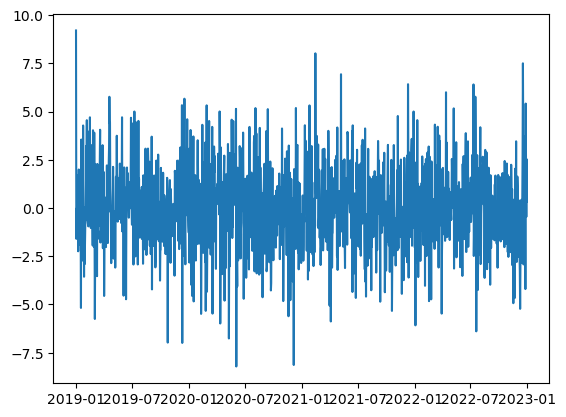

In [48]:
plt.plot(model519.resid)

#### Forecasting on test data using ARIMA(5,1,9)

In [49]:
forecast519 = model519.forecast(len(test))
forecast519

2023-01-01    9.295661
2023-01-02    9.275963
2023-01-03    8.774837
2023-01-04    8.040552
2023-01-05    8.421500
                ...   
2023-10-27    8.629093
2023-10-28    8.745296
2023-10-29    8.772820
2023-10-30    8.672170
2023-10-31    8.591261
Freq: D, Name: predicted_mean, Length: 304, dtype: float64

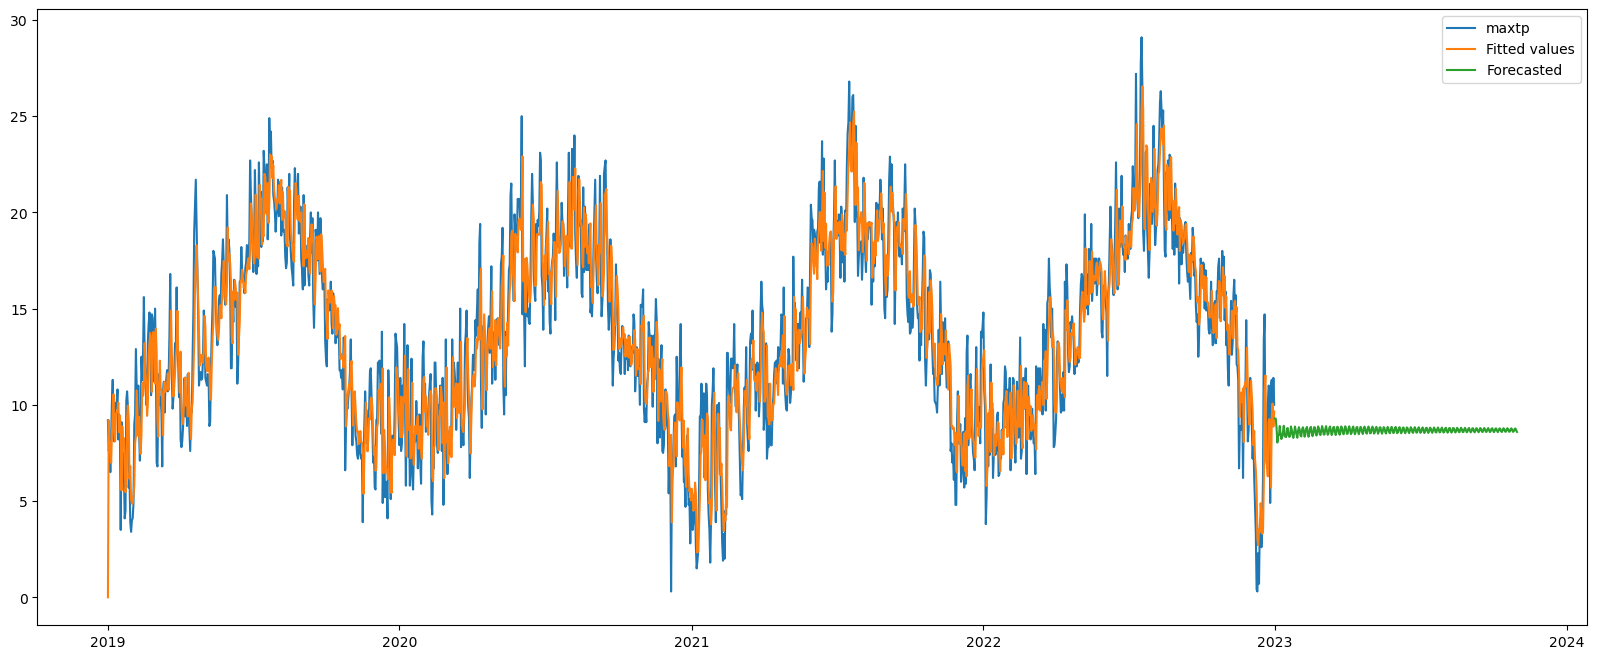

In [50]:
plt.figure(figsize = (20,8))
plt.plot(train['maxtp(Maximum Air Temperature - degrees C)'], label = 'maxtp')
plt.plot(model519.fittedvalues, label='Fitted values')
plt.plot(forecast519, label = 'Forecasted')
plt.legend()
plt.show()

#### Evaluation Metrics for ARIMA(5,1,9) model

In [51]:
model519_mae = mean_absolute_error(test['maxtp(Maximum Air Temperature - degrees C)'], forecast519)
model519_mape = mean_absolute_percentage_error(test['maxtp(Maximum Air Temperature - degrees C)'],forecast519)
model519_rmse = np.sqrt(mean_squared_error(test['maxtp(Maximum Air Temperature - degrees C)'], forecast519))
print("Mean Absolute Error (MAE): ",model519_mae)
print("Mean Absolute Percentage Error (MAPE): ",model519_mape)
print("Root Mean Squared Error (RMSE): ",model519_rmse)

Mean Absolute Error (MAE):  6.8303122060913735
Mean Absolute Percentage Error (MAPE):  0.4327633363116042
Root Mean Squared Error (RMSE):  7.946940343904504


In [52]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1461 entries, 2019-01-01 to 2022-12-31
Data columns (total 4 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   maxtp(Maximum Air Temperature - degrees C)  1461 non-null   float64
 1   mov_avg2                                    1460 non-null   float64
 2   mov_avg3                                    1459 non-null   float64
 3   weight_mov_avg3                             1459 non-null   float64
dtypes: float64(4)
memory usage: 57.1 KB


In [53]:
train_sarima = pd.DataFrame(train['maxtp(Maximum Air Temperature - degrees C)'].resample("M").mean())
train_sarima.head()

,maxtp(Maximum Air Temperature - degrees C)
date,
2019-01-31,7.774194
2019-02-28,11.160714
2019-03-31,11.367742
2019-04-30,12.056667
2019-05-31,14.712903


In [54]:
test_sarima = pd.DataFrame(test['maxtp(Maximum Air Temperature - degrees C)'].resample("M").mean())
test_sarima.head()

,maxtp(Maximum Air Temperature - degrees C)
date,
2023-01-31,8.777419
2023-02-28,10.350000
2023-03-31,10.422581
2023-04-30,12.696667
2023-05-31,16.658065


### Plotting the ACF plot for SARIMA model

<Figure size 1200x500 with 0 Axes>

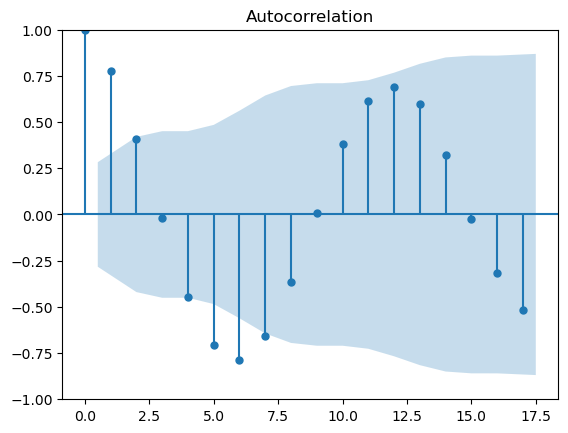

In [55]:
plt.figure(figsize=(12,5))
plot_acf(train_sarima['maxtp(Maximum Air Temperature - degrees C)'])
plt.show()

### Plotting the PACF plot for SARIMA model

C:\Users\Yash Bhargava\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 1200x500 with 0 Axes>

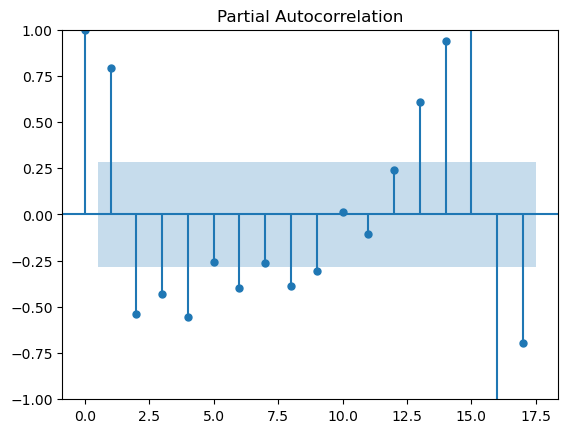

In [56]:
plt.figure(figsize=(12,5))
plot_pacf(train_sarima['maxtp(Maximum Air Temperature - degrees C)'])
plt.show()

## Seasonal ARIMA (SARIMA)

### SARIMA(1,1,2)(1,1,1)

In [57]:
sarima_model112111 = SARIMAX(train_sarima['maxtp(Maximum Air Temperature - degrees C)'], order=(1,1,2), seasonal_order= (1,1,1,12)).fit()

C:\Users\Yash Bhargava\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Yash Bhargava\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


#### Forecasting the test data values

In [58]:
sarima_model112111_forecast = sarima_model112111.forecast(len(test_sarima))
sarima_model112111_forecast                                  

2023-01-31     8.273576
2023-02-28    10.087764
2023-03-31    11.486624
2023-04-30    12.628179
2023-05-31    15.784067
2023-06-30    18.676289
2023-07-31    20.813621
2023-08-31    19.824721
2023-09-30    18.502075
2023-10-31    14.912896
Freq: M, Name: predicted_mean, dtype: float64

#### Plotting the SARIMA model

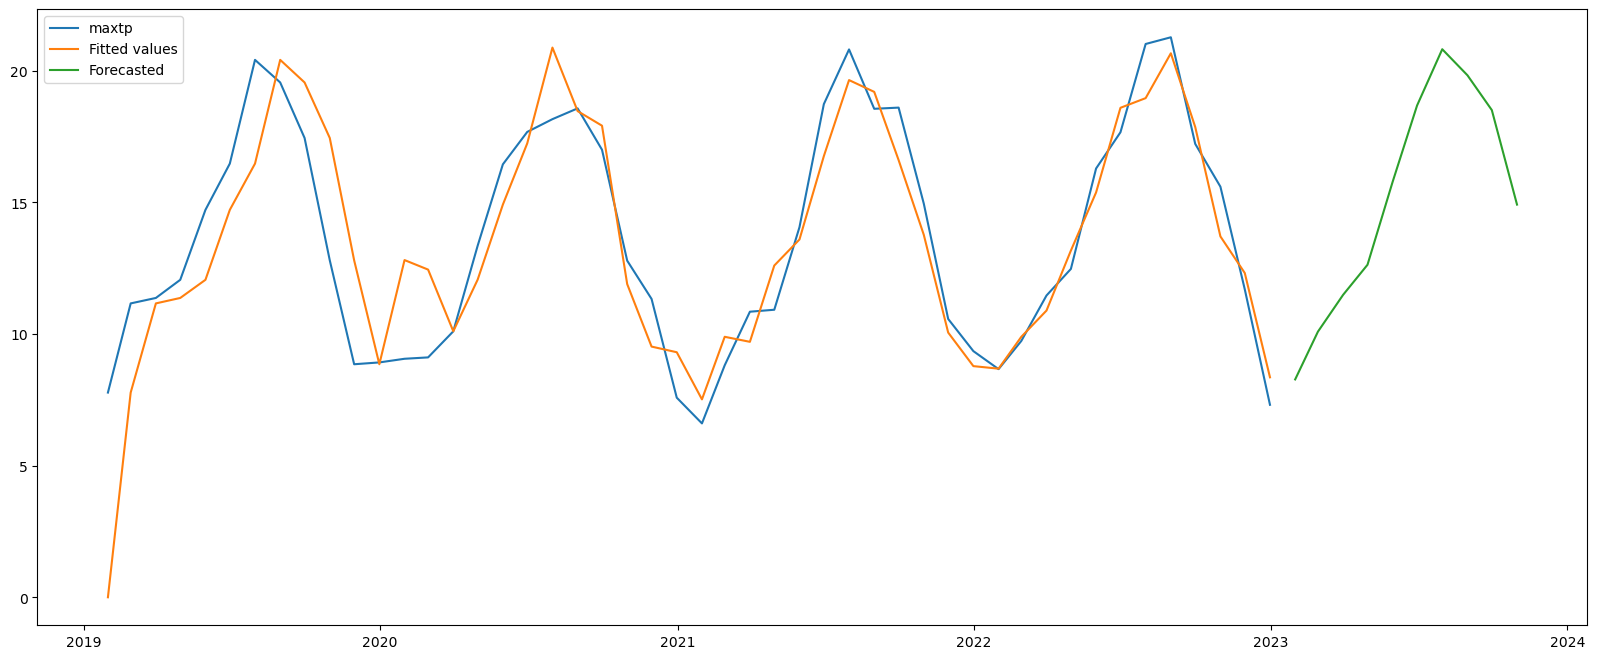

In [59]:
plt.figure(figsize = (20,8))
plt.plot(train_sarima['maxtp(Maximum Air Temperature - degrees C)'], label = 'maxtp')
plt.plot(sarima_model112111.fittedvalues, label='Fitted values')
plt.plot(sarima_model112111_forecast, label = 'Forecasted')
plt.legend()
plt.show()

#### Evaluation Metrics

In [60]:
print(sarima_model112111.summary())

                                           SARIMAX Results                                            
Dep. Variable:     maxtp(Maximum Air Temperature - degrees C)   No. Observations:                   48
Model:                       SARIMAX(1, 1, 2)x(1, 1, [1], 12)   Log Likelihood                 -57.898
Date:                                        Mon, 01 Jan 2024   AIC                            127.796
Time:                                                21:03:07   BIC                            137.128
Sample:                                            01-31-2019   HQIC                           131.017
                                                 - 12-31-2022                                         
Covariance Type:                                          opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4

In [61]:
sarima_model112111_mae = mean_absolute_error(test_sarima['maxtp(Maximum Air Temperature - degrees C)'], sarima_model112111_forecast)
sarima_model112111_mape = mean_absolute_percentage_error(test_sarima['maxtp(Maximum Air Temperature - degrees C)'],sarima_model112111_forecast)
sarima_model112111_rmse = np.sqrt(mean_squared_error(test_sarima['maxtp(Maximum Air Temperature - degrees C)'], sarima_model112111_forecast))

In [62]:
print("Mean Absolute Error (MAE): ",sarima_model112111_mae)
print("Mean Absolute Percentage Error (MAPE): ",sarima_model112111_mape)
print("Root Mean Squared Error (RMSE): ",sarima_model112111_rmse)

Mean Absolute Error (MAE):  0.6811624288639291
Mean Absolute Percentage Error (MAPE):  0.04572370229653501
Root Mean Squared Error (RMSE):  0.914747142611573


### SARIMA(1,1,3)(1,1,1)

In [63]:
sarima_model113111 = SARIMAX(train_sarima['maxtp(Maximum Air Temperature - degrees C)'], order=(1,1,3), seasonal_order= (1,1,1,12)).fit()

C:\Users\Yash Bhargava\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Yash Bhargava\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Yash Bhargava\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### Forecasting the test data values

In [64]:
sarima_model113111_forecast = sarima_model113111.forecast(len(test_sarima))
sarima_model113111_forecast   

2023-01-31     8.883841
2023-02-28    10.796607
2023-03-31    11.608933
2023-04-30    13.012882
2023-05-31    16.059025
2023-06-30    18.536683
2023-07-31    20.738896
2023-08-31    19.949596
2023-09-30    18.501170
2023-10-31    14.593648
Freq: M, Name: predicted_mean, dtype: float64

#### Plotting the SARIMA model

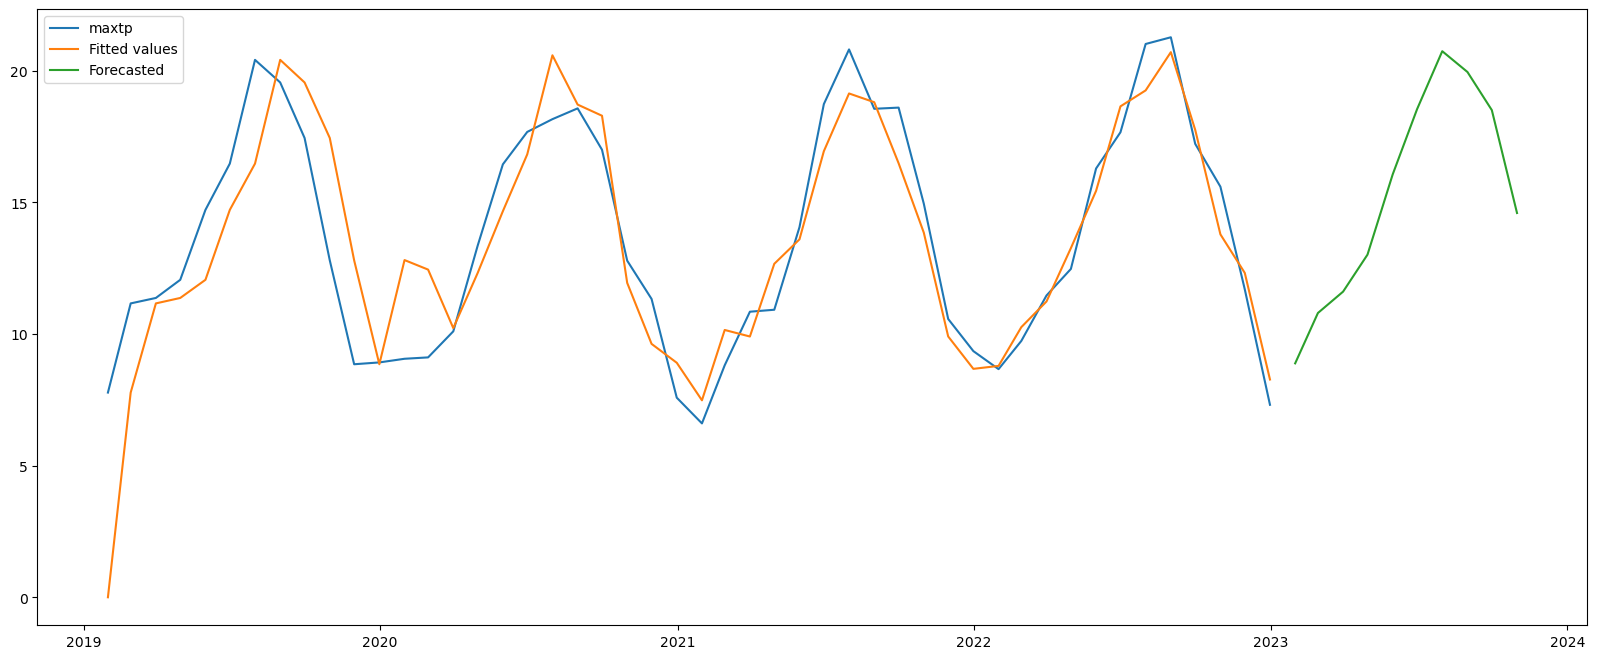

In [65]:
plt.figure(figsize = (20,8))
plt.plot(train_sarima['maxtp(Maximum Air Temperature - degrees C)'], label = 'maxtp')
plt.plot(sarima_model113111.fittedvalues, label='Fitted values')
plt.plot(sarima_model113111_forecast, label = 'Forecasted')
plt.legend()
plt.show()

#### Evaluation Metrics

In [66]:
print(sarima_model113111.summary())

                                           SARIMAX Results                                            
Dep. Variable:     maxtp(Maximum Air Temperature - degrees C)   No. Observations:                   48
Model:                       SARIMAX(1, 1, 3)x(1, 1, [1], 12)   Log Likelihood                 -57.175
Date:                                        Mon, 01 Jan 2024   AIC                            128.350
Time:                                                21:03:10   BIC                            139.238
Sample:                                            01-31-2019   HQIC                           132.108
                                                 - 12-31-2022                                         
Covariance Type:                                          opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1

In [67]:
sarima_model113111_mae = mean_absolute_error(test_sarima['maxtp(Maximum Air Temperature - degrees C)'], sarima_model113111_forecast)
sarima_model113111_mape = mean_absolute_percentage_error(test_sarima['maxtp(Maximum Air Temperature - degrees C)'],sarima_model113111_forecast)
sarima_model113111_rmse = np.sqrt(mean_squared_error(test_sarima['maxtp(Maximum Air Temperature - degrees C)'], sarima_model113111_forecast))

In [68]:
print("Mean Absolute Error (MAE): ",sarima_model113111_mae)
print("Mean Absolute Percentage Error (MAPE): ",sarima_model113111_mape)
print("Root Mean Squared Error (RMSE): ",sarima_model113111_rmse)

Mean Absolute Error (MAE):  0.7203562437841036
Mean Absolute Percentage Error (MAPE):  0.047536503696238776
Root Mean Squared Error (RMSE):  0.9235549123257781


### SARIMA(1,1,2)(0,1,1)

In [69]:
sarima_model112011 = SARIMAX(train_sarima['maxtp(Maximum Air Temperature - degrees C)'], order=(1,1,2), seasonal_order= (0,1,1,12)).fit()

C:\Users\Yash Bhargava\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Yash Bhargava\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


#### Forecasting the values for test data

In [70]:
sarima_model112011_forecast = sarima_model112011.forecast(len(test_sarima))
sarima_model112011_forecast   

2023-01-31     8.491417
2023-02-28    10.458617
2023-03-31    11.560660
2023-04-30    12.882197
2023-05-31    16.025242
2023-06-30    18.298219
2023-07-31    20.758514
2023-08-31    20.141523
2023-09-30    18.236747
2023-10-31    14.667603
Freq: M, Name: predicted_mean, dtype: float64

#### Plotting the SARIMA model

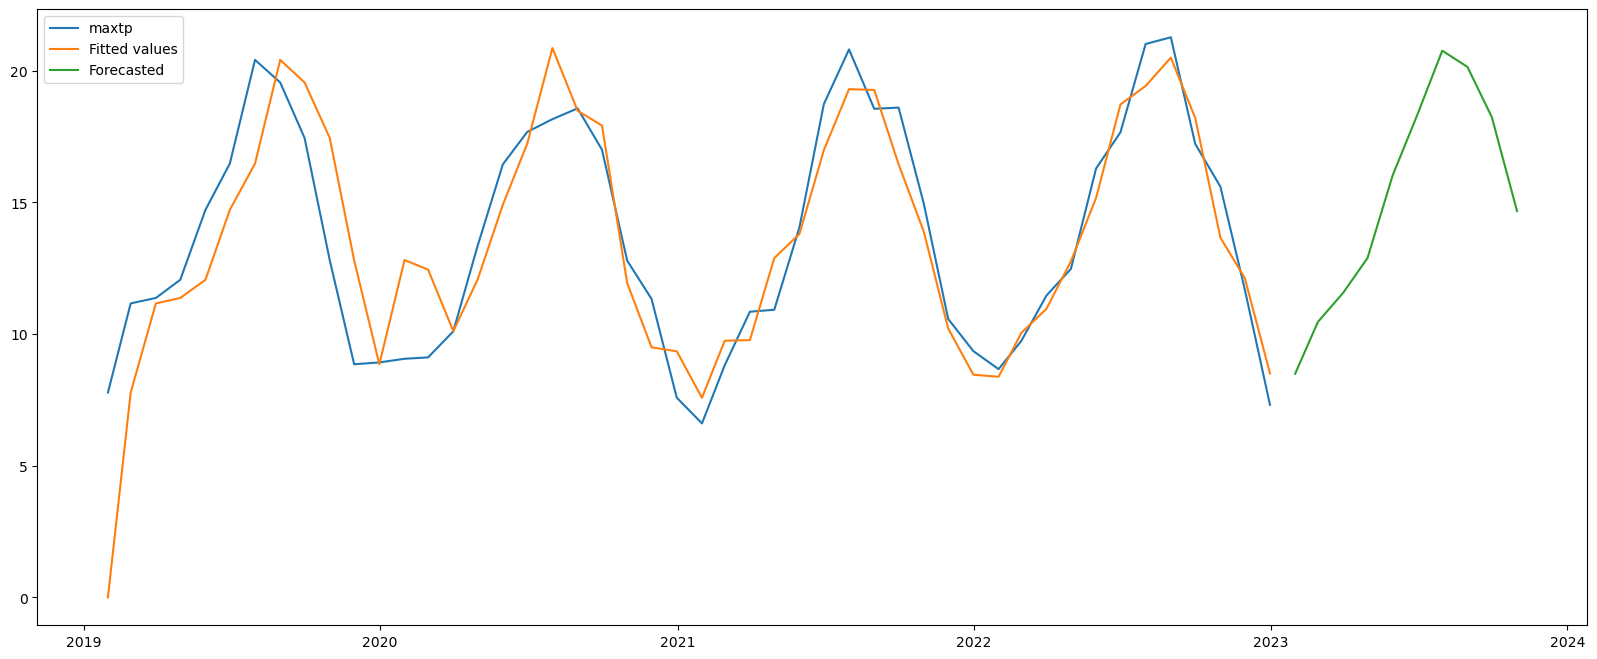

In [71]:
plt.figure(figsize = (20,8))
plt.plot(train_sarima['maxtp(Maximum Air Temperature - degrees C)'], label = 'maxtp')
plt.plot(sarima_model112011.fittedvalues, label='Fitted values')
plt.plot(sarima_model112011_forecast, label = 'Forecasted')
plt.legend()
plt.show()

#### Evaluation Metrics

In [72]:
print(sarima_model112011.summary())

                                           SARIMAX Results                                            
Dep. Variable:     maxtp(Maximum Air Temperature - degrees C)   No. Observations:                   48
Model:                       SARIMAX(1, 1, 2)x(0, 1, [1], 12)   Log Likelihood                 -58.363
Date:                                        Mon, 01 Jan 2024   AIC                            126.726
Time:                                                21:03:11   BIC                            134.503
Sample:                                            01-31-2019   HQIC                           129.411
                                                 - 12-31-2022                                         
Covariance Type:                                          opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4

In [73]:
sarima_model112011_mae = mean_absolute_error(test_sarima['maxtp(Maximum Air Temperature - degrees C)'], sarima_model112011_forecast)
sarima_model112011_mape = mean_absolute_percentage_error(test_sarima['maxtp(Maximum Air Temperature - degrees C)'],sarima_model112011_forecast)
sarima_model112011_rmse = np.sqrt(mean_squared_error(test_sarima['maxtp(Maximum Air Temperature - degrees C)'], sarima_model112011_forecast))

In [74]:
print("Mean Absolute Error (MAE): ",sarima_model112011_mae)
print("Mean Absolute Percentage Error (MAPE): ",sarima_model112011_mape)
print("Root Mean Squared Error (RMSE): ",sarima_model112011_rmse)

Mean Absolute Error (MAE):  0.7540453980129149
Mean Absolute Percentage Error (MAPE):  0.04826452897698308
Root Mean Squared Error (RMSE):  0.9675040327777003
